In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input,BatchNormalization,ReLU,LeakyReLU,GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1,l2,l1_l2
import matplotlib.pyplot as plt

In [ ]:
# def analyze_durations(directory):
#     durations = []
#     for filename in os.listdir(directory):
#         if filename.endswith('.wav'):
#             file_path = os.path.join(directory, filename)
#             try:
#                 duration = librosa.get_duration(path=file_path)
#                 durations.append(duration)
#             except Exception as e:
#                 print(f"Could not read {file_path}: {e}")
#     return durations

# siren_durations = analyze_durations(SIREN_DIR)
# noise_durations = analyze_durations(NOISE_DIR)

# print(f"Siren durations: Avg={np.mean(siren_durations):.2f}s, Min={np.min(siren_durations):.2f}s, Max={np.max(siren_durations):.2f}s")
# print(f"Noise durations: Avg={np.mean(noise_durations):.2f}s, Min={np.min(noise_durations):.2f}s, Max={np.max(noise_durations):.2f}s")

In [2]:

SIREN_DIR = '../data/dataset/siren'  
NOISE_DIR = '../data/dataset/road_noise'  

SAMPLE_RATE = 48000  




In [3]:

def load_and_process_data(siren_dir, noise_dir):
    X = []
    y = []

    for filename in os.listdir(siren_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(siren_dir, filename)
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            
            emphasized_audio = librosa.effects.preemphasis(audio, coef=0.97)
            X.append(emphasized_audio)
            y.append(1)


    # Process Noise files (label=0)
    for filename in os.listdir(noise_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(noise_dir, filename)
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
            X.append(audio)
            y.append(0)
    
    return np.array(X), np.array(y)

X, y = load_and_process_data(SIREN_DIR, NOISE_DIR)
print(f"Loaded {len(X)} audio files.")

e:\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Loaded 3073 audio files.


In [5]:
count = (y == 0).sum()
count

1649

In [4]:
# --- 3. Extract MFCCs ---
def extract_mfcc(audio_data, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Apply MFCC extraction to the entire dataset
X_mfcc = np.array([extract_mfcc(audio, SAMPLE_RATE) for audio in X])
print(f"MFCC features extracted. Shape: {X_mfcc.shape}")

MFCC features extracted. Shape: (3073, 13, 376)


In [ ]:
plt.figure(figsize=(15, 5))
examp_mfcc = X_mfcc[3]
librosa.display.specshow(examp_mfcc, sr=SAMPLE_RATE, x_axis='time')

plt.colorbar(format='%+2.0f dB')

plt.title('MFCC')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(15, 5))
examp_mfcc = X_mfcc[3000] #road848_segment_2
librosa.display.specshow(examp_mfcc, sr=SAMPLE_RATE, x_axis='time')

plt.colorbar(format='%+2.0f dB')

plt.title('MFCC')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(15, 5))
examp_mfcc = X_mfcc[-2] #road848_segment_2
librosa.display.specshow(examp_mfcc, sr=SAMPLE_RATE, x_axis='time')

plt.colorbar(format='%+2.0f dB')

plt.title('MFCC')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()


In [5]:
# --- 4. Prepare Data for CNN and Train ---

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mfcc, y, test_size=0.4, random_state=42, stratify=y) # stratify is good practice for classification

# Add the "channel" dimension for the CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (1843, 13, 376, 1)
Test data shape: (1230, 13, 376, 1)


In [6]:


# Define the CNN Model
input_shape = X_train.shape[1:]

def create_cnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),

        # Block 1
        Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
   
        Dropout(0.2),

        # Block 2
        Conv2D(64, kernel_size=(3, 3), padding='same', strides=(2, 2)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        
        Dropout(0.3),

        # # Block 3
        Conv2D(128, kernel_size=(3, 3), padding='same', strides=(2, 2)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        
        Dropout(0.3),

        # Block 4
        # Conv2D(256, kernel_size=(3, 3), padding='same', strides=(2, 2)),
        # BatchNormalization(),
        # LeakyReLU(alpha=0.01),
        # Dropout(0.4),

        # Global Average Pooling instead of Flatten
        GlobalAveragePooling2D(),

        # Fully connected layers
        Dense(128, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.5),

        Dense(64, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])
    return model





In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve,roc_auc_score,auc
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:

epochs = 100

model = create_cnn_model(input_shape)
model.summary()

C:\Users\GOWRI SHANKAR\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 376, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 376, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 13, 376, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 376, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 188, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 188, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 188, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 188, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 94, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 94, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 94, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 94, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            6

 Total params: 119,169 (465.50 KB)

 Trainable params: 118,337 (462.25 KB)

 Non-trainable params: 832 (3.25 KB)

In [9]:

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])


print("Training the model...")
history = model.fit(X_train, y_train,
                    epochs=epochs,  
                    batch_size=32,
                    validation_split=0.3)

# Extract the metrics from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_acc) + 1)


Training the model...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.8436 - loss: 0.5600 - val_accuracy: 0.7649 - val_loss: 0.5909
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9796 - loss: 0.2917 - val_accuracy: 0.6691 - val_loss: 0.6547
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9929 - loss: 0.2327 - val_accuracy: 0.9494 - val_loss: 0.4126
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9864 - loss: 0.2277 - val_accuracy: 0.9801 - val_loss: 0.2482
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9861 - loss: 0.2074 - val_accuracy: 0.9385 - val_loss: 0.2951
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9918 - loss: 0.1823 - val_accuracy: 0.9638 - val_loss: 0.2311
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9877 - loss: 0.1810 - val_accuracy: 0.9439 - val_loss: 0.2663
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9954 - loss: 0.1

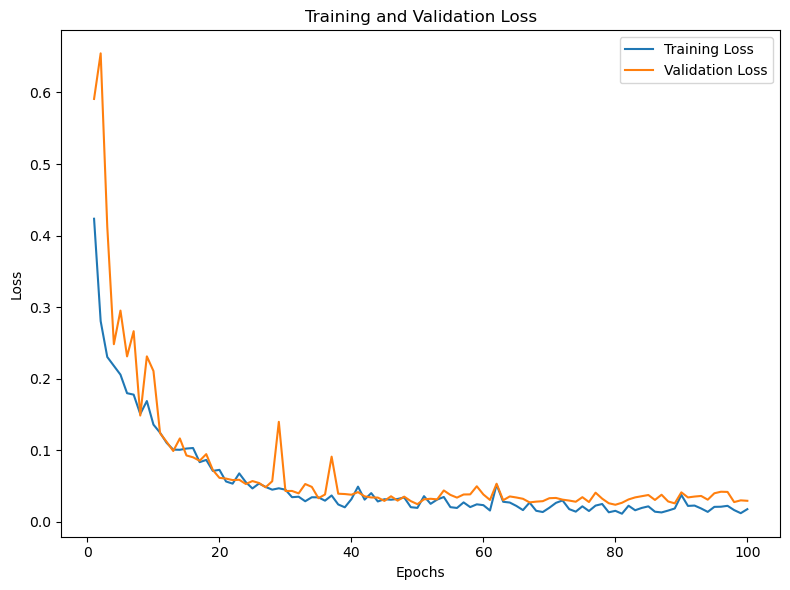

In [10]:
#Plot of trainning Loss 

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:

# Highlight the best epoch
# best_epoch = np.argmin(val_loss) + 1
# plt.axvline(best_epoch, linestyle='--', color='k', label=f'Best Epoch: {best_epoch}')
# plt.legend()


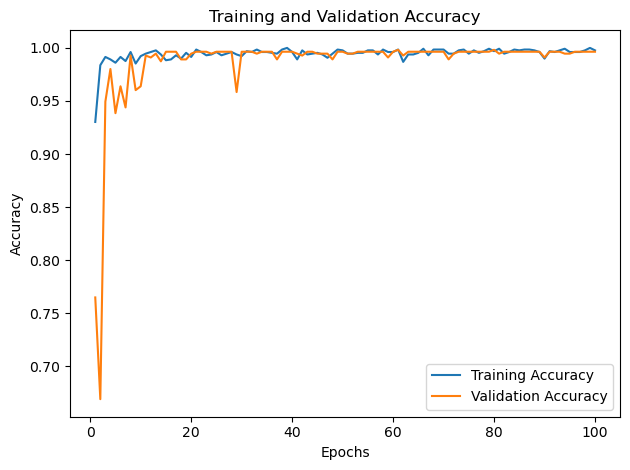

In [11]:
#Plot for training accuracy

plt.plot(epochs_range, train_acc,  label='Training Accuracy')
plt.plot(epochs_range, val_acc,  label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
#Going with optimal epochs
best_epoch = 50

model1 = create_cnn_model(input_shape)
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


print("Training the model...")
model1.fit(X_train, y_train,epochs=best_epoch, batch_size=32,validation_split=0.3)

Training the model...
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.8780 - loss: 0.5319 - val_accuracy: 0.8807 - val_loss: 0.4955
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9810 - loss: 0.2942 - val_accuracy: 0.7197 - val_loss: 0.6169
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9852 - loss: 0.2563 - val_accuracy: 0.8680 - val_loss: 0.4884
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9957 - loss: 0.2217 - val_accuracy: 0.6618 - val_loss: 0.7141
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9850 - loss: 0.2166 - val_accuracy: 0.8716 - val_loss: 0.4542
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9929 - loss: 0.1805 - val_accuracy: 0.9910 - val_loss: 0.1840
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9921 - loss: 0.1694 - val_accuracy: 0.9295 - val_loss: 0.3263
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9815 - loss: 0.1818 - va

In [13]:
loss,acc = model1.evaluate(X_test,y_test)
print(loss,acc)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9967 - loss: 0.0330
0.02665676362812519 0.9967479705810547


In [14]:
class_names = ['Road Noise', 'Siren']
y_pred_proba = model1.predict(X_test)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


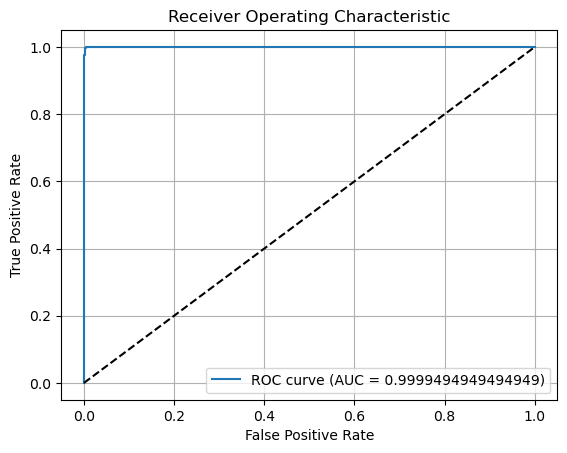

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [20]:
thresolds = [0.25,0.5,0.75]
cms = []

for i in thresolds:
    y_pred_proba = model1.predict(X_test)
    y_pred = (y_pred_proba > i).astype("int32").reshape(-1)
    cm = confusion_matrix(y_test, y_pred)
    cms.append(cm)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


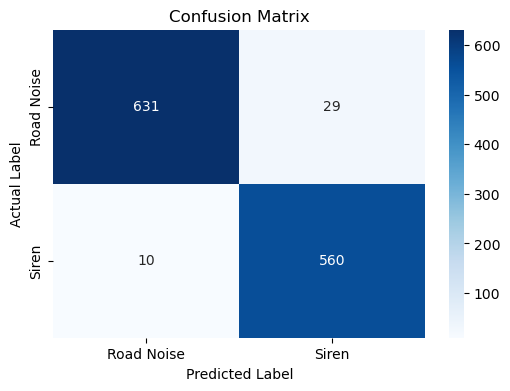

precision = 0.9507640067911715
recall = 0.9824561403508771
specificity = 0.956060606060606
f1_score = 0.9663503019844694
accuracy = 0.9682926829268292


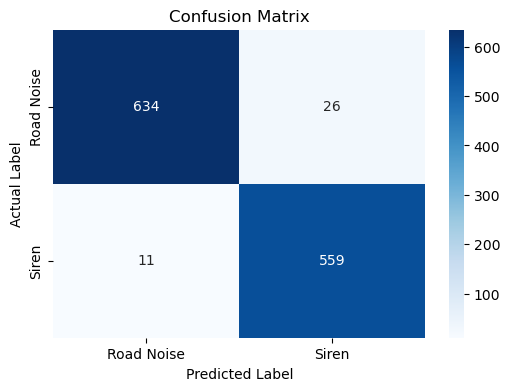

precision = 0.9555555555555556
recall = 0.980701754385965
specificity = 0.9606060606060606
f1_score = 0.967965367965368
accuracy = 0.9699186991869919


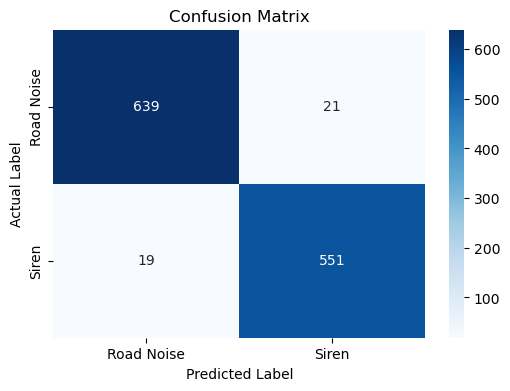

precision = 0.9632867132867133
recall = 0.9666666666666667
specificity = 0.9681818181818181
f1_score = 0.9649737302977233
accuracy = 0.967479674796748


In [23]:
class_names = ['Road Noise', 'Siren']
precisionL = []
recallL = []
specificityL = []
f1_scoreL = []
accuracyL = []
for i in range(len(cms)):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cms[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title(f'Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    tn, fp, fn, tp = cms[i].ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    print('precision =',precision)
    print('recall =',recall)
    print('specificity =',specificity)
    print('f1_score =',f1_score)
    print('accuracy =',accuracy)

    precisionL.append(precision)
    recallL.append(recall)
    specificityL.append(specificity)
    f1_scoreL.append(f1_score)
    accuracyL.append(accuracy)



In [ ]:
# plt.figure(figsize=(30,10))
# plt.suptitle('classifcation report based on Thresolds')

# plt.subplot(2,3,1)
# plt.title('precision')
# plt.stem(thresolds,precisionL)
# plt.ylim(0.85,1)

# plt.subplot(2,3,2)
# plt.title('recall')
# plt.stem(thresolds,recallL)
# plt.ylim(0.85,1)

# plt.subplot(2,3,3)
# plt.title('specificity')
# plt.stem(thresolds,specificityL)
# plt.ylim(0.85,1)

# plt.subplot(2,3,4)
# plt.title('f1_score')
# plt.stem(thresolds,f1_scoreL)
# plt.ylim(0.85,1)

# plt.subplot(2,3,5)
# plt.title('accuracy')
# plt.stem(thresolds,accuracyL)
# plt.ylim(0.85,1)
# plt.show()



In [ ]:


# # 1. Get model predictions
# y_pred_proba = model.predict(X_test)
# y_pred = (y_pred_proba > i).astype("int32").reshape(-1) # Reshape to 1D array

# # 2. Compute the confusion matrix
# cm = confusion_matrix(y_test, y_pred)

# # 3. Define class names
# class_names = ['Road Noise', 'Siren']

# # 4. Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)

# plt.title('Confusion Matrix')
# plt.ylabel('Actual Label')
# plt.xlabel('Predicted Label')
# plt.show()

# # 5. (Optional) Print classification report for more metrics
# from sklearn.metrics import classification_report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=class_names))